In [1]:
from quickdb.datarake import master
from tqdm import tqdm

### helper functions

In [2]:
def getbody(func):
    import inspect
    return '\n'.join(inspect.getsource(func).split('\n')[1:])

In [3]:
import contextlib

@contextlib.contextmanager
def progress_bar():
    with tqdm(total=1, ncols=120) as pbar:
        def progress(p):
            pbar.total = p.total
            pbar.n = p.done
            pbar.refresh()
        yield progress

### 1D histogram

100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 88.77it/s]


CPU times: user 268 ms, sys: 68.8 ms, total: 337 ms
Wall time: 1.44 s


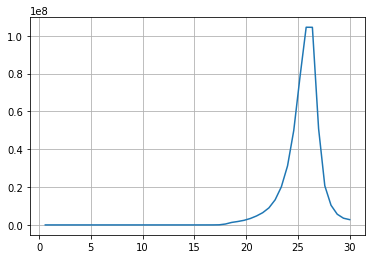

In [4]:
def make_env():
    import numpy

    rerun = 'pdr2_wide'

    def flux2mag(flux):
         return -2.5 * numpy.log10(flux * (10**-9) / 3631.)

    def mapper(patch):
        mag = flux2mag(patch('forced.i.psfflux_flux'))
        return numpy.histogram(mag, bins=50, range=(0, 30))

    def reducer(a, b):
        return a[0] + b[0], a[1]

with progress_bar() as progress:
    %time result = master.run_make_env(getbody(make_env), {}, progress)

%matplotlib inline
from matplotlib import pyplot

hist, bins = result
pyplot.plot(bins[1:], hist)
pyplot.grid()

### 2D histogram

100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 57.00it/s]

CPU times: user 331 ms, sys: 188 ms, total: 519 ms
Wall time: 2.24 s


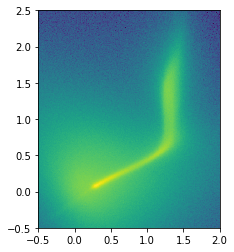

In [5]:
def make_env():
    import numpy

    rerun = 'pdr2_wide'

    def flux2mag(flux):
         return -2.5 * numpy.log10(flux * (10**-9) / 3631.)

    def mapper(patch):
        patch = patch[patch('forced.i.extendedness_value') < 0.5]
        g = flux2mag(patch('forced.g.psfflux_flux'))
        r = flux2mag(patch('forced.r.psfflux_flux'))
        i = flux2mag(patch('forced.i.psfflux_flux'))
        return numpy.histogram2d(g - r, r - i, bins=(400, 800), range=((-0.5, 2), (-0.5, 2.5)))

    def reducer(a, b):
        return a[0] + b[0], a[1], a[2]

with progress_bar() as progress:
    %time result = master.run_make_env(getbody(make_env), {}, progress)

import numpy

hist, xedges, yedges = result
pyplot.imshow(numpy.log(1 + hist).T, origin='low', extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]))

### SQL interface

In [6]:
from quickdb.sql2mapreduce import run_sql

In [7]:
sql = '''
    SELECT
        COUNT(*)
    FROM
        pdr2_wide
    GROUP BY
        forced.isprimary
'''

with progress_bar() as progress:
    %time result = run_sql(sql, master.run_make_env, progress=progress)


from collections import OrderedDict
import pandas

pandas.DataFrame.from_dict(OrderedDict(zip(result.target_names, result.target_list)))

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 253.60it/s]


CPU times: user 250 ms, sys: 73.9 ms, total: 324 ms
Wall time: 503 ms


,$group_by,col0
0,"(False,)",275792529
1,"(True,)",436330902


In [8]:
sql = '''
    SELECT
        object_id, flux2mag(forced.i.psfflux_flux), forced.coord[0] as coord0
    FROM
        pdr2_wide
    WHERE
        forced.isprimary
    ORDER BY
        flux2mag(forced.i.psfflux_flux) - flux2mag(forced.r.psfflux_flux)
        DESC
    LIMIT 1000
'''

from quickdb.sspcatalog.errors import UserError

with progress_bar() as progress:
    result = run_sql(sql, master.run_make_env, progress=progress)

from collections import OrderedDict
import pandas

pandas.DataFrame.from_dict(OrderedDict(zip(result.target_names, result.target_list)))

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 141.60it/s]


,col0,col1,coord0
0,39908432387507911,88.940399,-142778.390625
1,39908432387507916,69.951324,-142785.312500
2,39948289684014622,66.730927,-172566.046875
3,39908432387507901,67.858444,-142770.890625
4,39939218713085497,66.609329,-167357.281250
...,...,...,...
995,43145124036739592,24.933964,-171199.437500
996,39939218713084064,26.537594,-167326.359375
997,39961071506686884,26.070406,-181944.343750
998,40048757559001512,28.898979,-205945.875000


In [9]:
sql = '''
    SELECT
        sleep(2)
    FROM
        pdr2_dud
'''

with progress_bar() as progress:
    %time result = run_sql(sql, master.run_make_env, progress=progress)

100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 58.57it/s]

CPU times: user 186 ms, sys: 72.4 ms, total: 258 ms
Wall time: 2.18 s
